In [1]:
# DATASET LOADING

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matminer.datasets import load_dataset
from pymatgen.core import Composition

# Load the experimental band gap dataset from matminer
expt_gap = load_dataset("expt_gap")
print("Experimental Band Gap Dataset Shape:", expt_gap.shape)
print("First few rows:")
print(expt_gap.head())

# Convert the chemical formula strings into pymatgen Composition objects
expt_gap['composition'] = expt_gap['formula'].apply(lambda x: Composition(x))

# Verify the conversion by displaying the formula and the corresponding composition
print(expt_gap[['formula', 'composition']].head())

from matminer.featurizers.composition import ElementProperty

# Initialize the ElementProperty featurizer with the 'magpie' preset
ep_feat = ElementProperty.from_preset(preset_name="magpie")

# Featurize the dataset: this will add many new numerical feature columns based on the composition
features_df = ep_feat.featurize_dataframe(expt_gap, col_id="composition", ignore_errors=True)

# Display a few rows of the new feature-rich dataframe
print("Features dataframe head:")
print(features_df.head())

Experimental Band Gap Dataset Shape: (6354, 2)
First few rows:
        formula  gap expt
0  Hg0.7Cd0.3Te      0.35
1          CuBr      3.08
2           LuP      1.30
3      Cu3SbSe4      0.40
4           ZnO      3.44
        formula   composition
0  Hg0.7Cd0.3Te  (Hg, Cd, Te)
1          CuBr      (Cu, Br)
2           LuP       (Lu, P)
3      Cu3SbSe4  (Cu, Sb, Se)
4           ZnO       (Zn, O)


/home/jovyan/.local/lib/python3.9/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/6354 [00:00<?, ?it/s]

Features dataframe head:
        formula  gap expt   composition  MagpieData minimum Number  \
0  Hg0.7Cd0.3Te      0.35  (Hg, Cd, Te)                       48.0   
1          CuBr      3.08      (Cu, Br)                       29.0   
2           LuP      1.30       (Lu, P)                       15.0   
3      Cu3SbSe4      0.40  (Cu, Sb, Se)                       29.0   
4           ZnO      3.44       (Zn, O)                        8.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       80.0                     32.0                   61.20   
1                       35.0                      6.0                   32.00   
2                       71.0                     56.0                   43.00   
3                       51.0                     22.0                   34.25   
4                       30.0                     22.0                   19.00   

   MagpieData avg_dev Number  MagpieData mode Number  \
0          

In [2]:
# PREPROCESSING STEPS

# Handle missing values

from sklearn.impute import SimpleImputer

# Count missing values before imputation
print("Missing values per column:")
print(features_df.isnull().sum().sort_values(ascending=False))

# Total missing values in the entire DataFrame
total_missing = features_df.isnull().sum().sum()
print(f"\n Total missing values: {total_missing}")

# Drop rows where the target 'gap' is missing
features_df = features_df.dropna(subset=['gap expt'])

# Separate features and target, drop non-numeric columns
X = features_df.drop(columns=['formula', 'composition', 'gap expt'])
y = features_df['gap expt']

# Fill missing feature values with mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_df = pd.DataFrame(X_imputed, columns=X.columns)

# Count missing values after imputation
print("\n Missing values per column after imputation:")
print(X_df.isnull().sum().sort_values(ascending=False))

# Total missing values in the entire DataFrame after imputation
total_missing = X_df.isnull().sum().sum()
print(f"\n Total missing values after imputation: {total_missing}")

Missing values per column:
MagpieData mode SpaceGroupNumber       1
MagpieData avg_dev SpaceGroupNumber    1
MagpieData mean SpaceGroupNumber       1
MagpieData range SpaceGroupNumber      1
MagpieData mode GSvolume_pa            1
                                      ..
MagpieData maximum MendeleevNumber     1
MagpieData range MendeleevNumber       1
composition                            0
gap expt                               0
formula                                0
Length: 135, dtype: int64

 Total missing values: 132

 Missing values per column after imputation:
MagpieData mode SpaceGroupNumber      0
MagpieData minimum Number             0
MagpieData maximum Number             0
MagpieData range Number               0
MagpieData range GSbandgap            0
                                     ..
MagpieData maximum MendeleevNumber    0
MagpieData range MendeleevNumber      0
MagpieData mean MendeleevNumber       0
MagpieData avg_dev MendeleevNumber    0
MagpieData mode Mendel

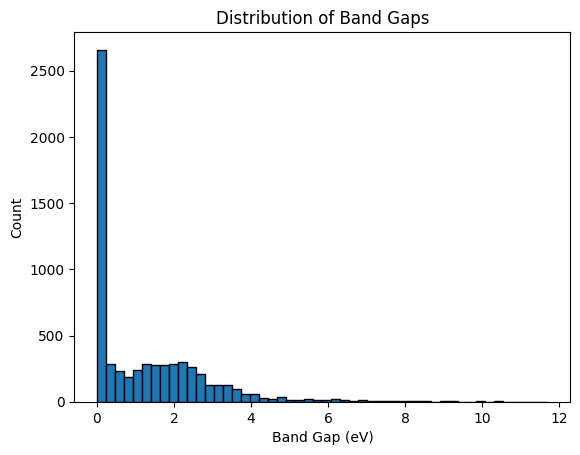

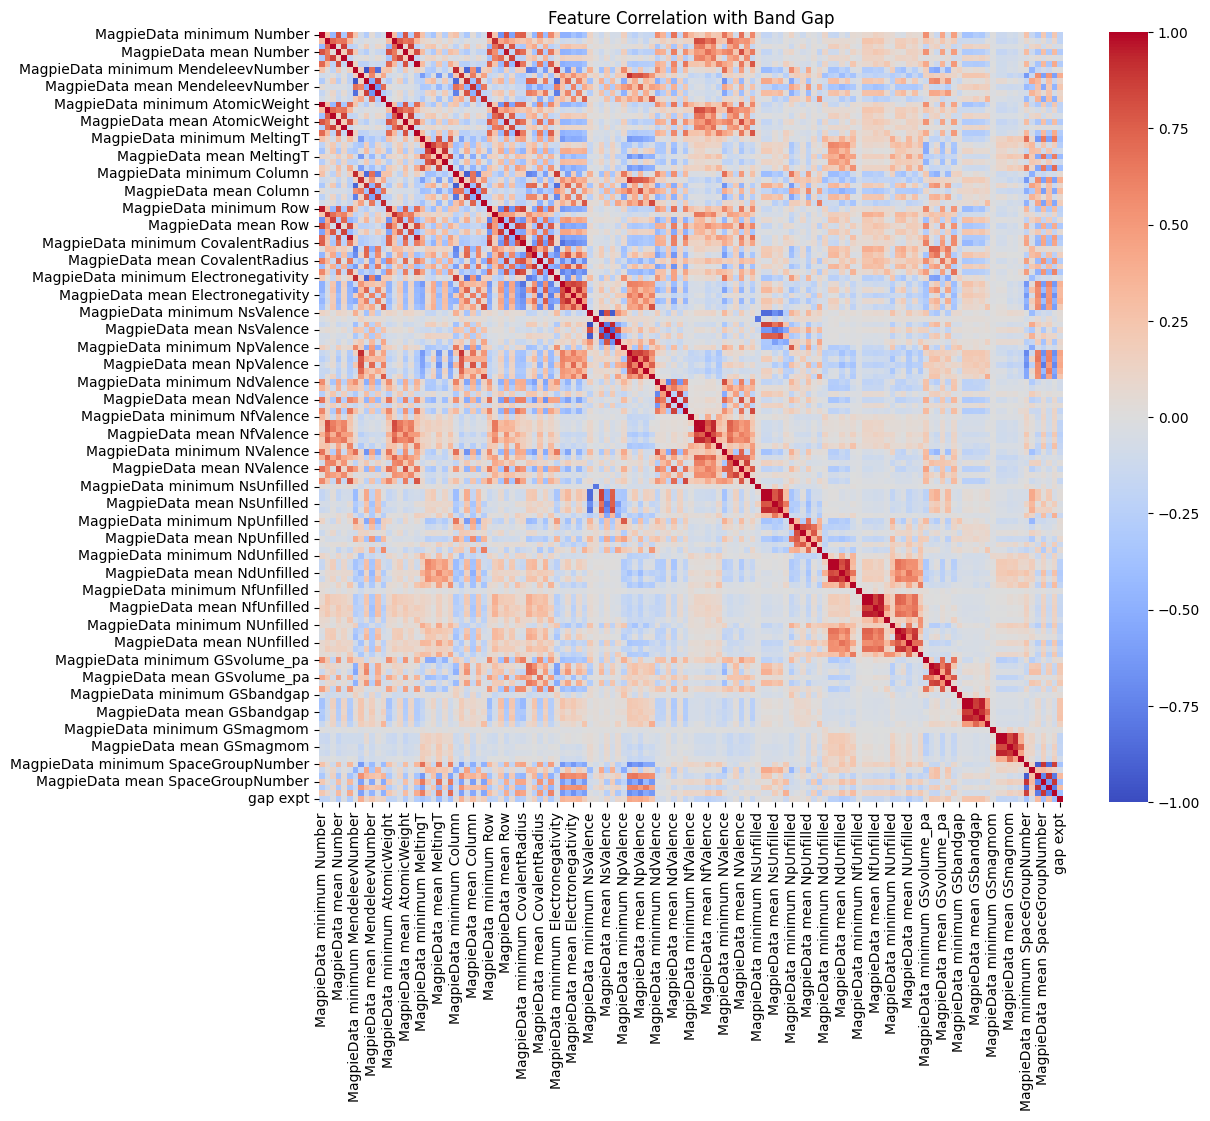

In [3]:
# EXPLORATORY DATA ANALYSIS (EDA)

import seaborn as sns

# Band gap distribution
plt.hist(y, bins=50, edgecolor='black')
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of Band Gaps")
plt.show()

# Correlation heatmap
corr_matrix_full = pd.concat([X_df, y.reset_index(drop=True)], axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_full, cmap="coolwarm", vmax=1, vmin=-1)
plt.title("Feature Correlation with Band Gap")
plt.show()

In [4]:
# Feature engineering

# Compute features correlation with the target
corr_matrix = pd.concat([X_df, y.reset_index(drop=True)], axis=1).corr()
target_corr = corr_matrix["gap expt"].drop("gap expt")

# Filter features with low correlation to the target
corr_threshold = 0.05
strong_features = target_corr[abs(target_corr) > corr_threshold].index.tolist()

print(f"Keeping {len(strong_features)} features with correlation to target > {corr_threshold}")

X_filtered = X_df[strong_features]

# Remove redundant features (highly correlated with each other)
input_corr_matrix = X_filtered.corr().abs()
lower_triangle = input_corr_matrix.where(np.tril(np.ones(input_corr_matrix.shape), k=-1).astype(bool))

# Identify columns to drop (threshold > 0.95)
to_drop = [column for column in lower_triangle.columns if any(lower_triangle[column] > 0.95)]
print(f"\nDropping {len(to_drop)} features that are highly correlated with each other:", to_drop)

# Final cleaned feature set
X_selected = X_filtered.drop(columns=to_drop)

print("\nUpdated Features Shape:", X_selected.shape)

Keeping 107 features with correlation to target > 0.05

Dropping 12 features that are highly correlated with each other: ['MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData mean Number', 'MagpieData mode Number', 'MagpieData mean AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData maximum NfValence', 'MagpieData maximum NdUnfilled', 'MagpieData maximum NfUnfilled', 'MagpieData range NfUnfilled', 'MagpieData maximum GSbandgap', 'MagpieData maximum GSmagmom']

Updated Features Shape: (6354, 95)


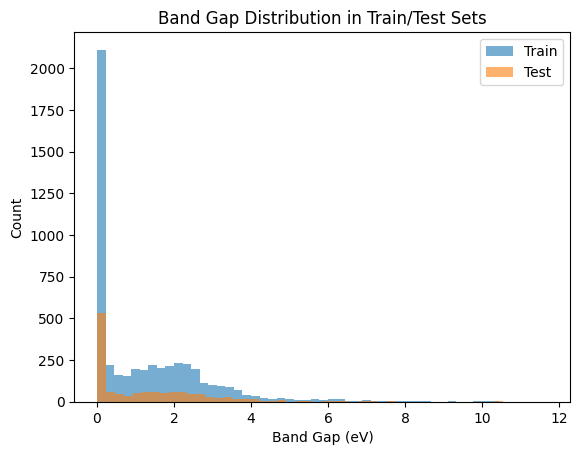

In [5]:
# DATA SPLITTING

from sklearn.model_selection import train_test_split
import pandas as pd

# Create bins for band gap values (stratified splitting)
#y_bins = pd.cut(y, bins=[-0.1, 0.5, 1, 2, 4, 8, 12], labels=False) # manual binning
y_bins = pd.qcut(y, q=10, duplicates='drop', labels=False) # to balance the stratified bins (auto binning)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y_bins, random_state=42)

# Plot to check
plt.hist(y_train, bins=50, alpha=0.6, label='Train')
plt.hist(y_test, bins=50, alpha=0.6, label='Test')
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count")
plt.legend()
plt.title("Band Gap Distribution in Train/Test Sets")
plt.show()

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Training Performance
MAE: 0.146, RMSE: 0.268, R²: 0.969

Test Performance
MAE: 0.334, RMSE: 0.642, R²: 0.832


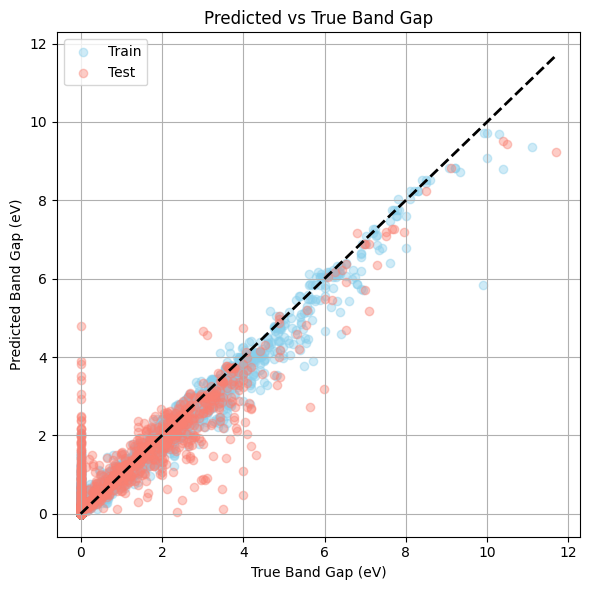

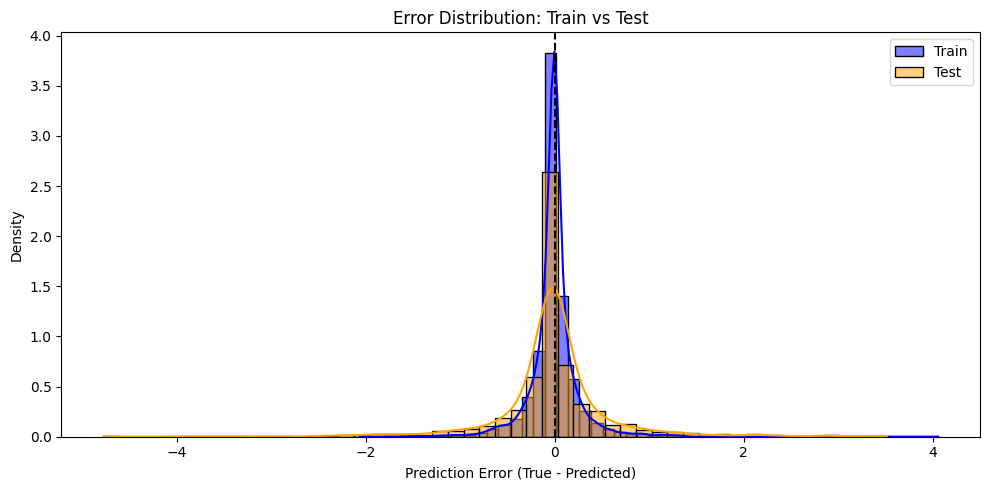

In [6]:
# BASELINE RANDOM FOREST MODEL

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train baseline model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(rf.get_params())

# Evaluate

# Training set metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Test set metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Print both
print("\nTraining Performance")
print(f"MAE: {train_mae:.3f}, RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")

print("\nTest Performance")
print(f"MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")

# Visualisation

plt.figure(figsize=(6, 6))

# Training predictions
plt.scatter(y_train, y_train_pred, alpha=0.4, label="Train", color="skyblue")

# Test predictions
plt.scatter(y_test, y_test_pred, alpha=0.4, label="Test", color="salmon")

# Reference line
min_val = min(y.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y.max(), y_train_pred.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs True Band Gap")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate residuals (errors)
train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

plt.figure(figsize=(10, 5))
sns.histplot(train_errors, kde=True, color="blue", label="Train", stat="density", bins=50)
sns.histplot(test_errors, kde=True, color="orange", label="Test", stat="density", bins=50)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Prediction Error (True - Predicted)")
plt.ylabel("Density")
plt.title("Error Distribution: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()

{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}

Optimized RF:
Training Performance Opt
MAE: 0.147, RMSE: 0.259, R²: 0.971

Test Performance Opt
MAE: 0.338, RMSE: 0.623, R²: 0.841


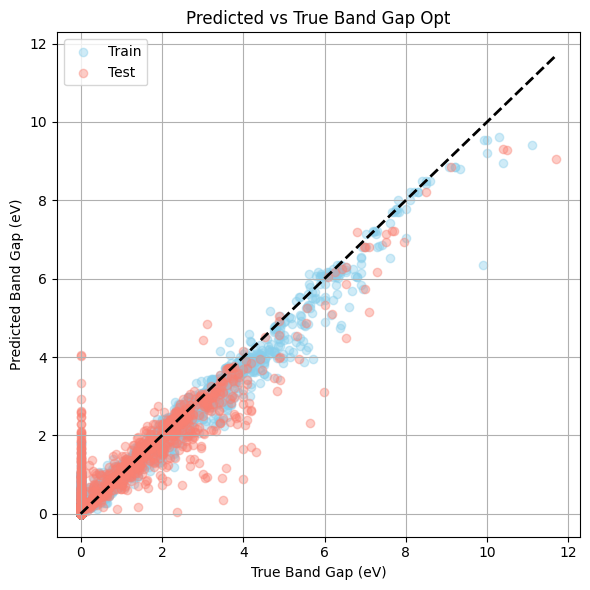

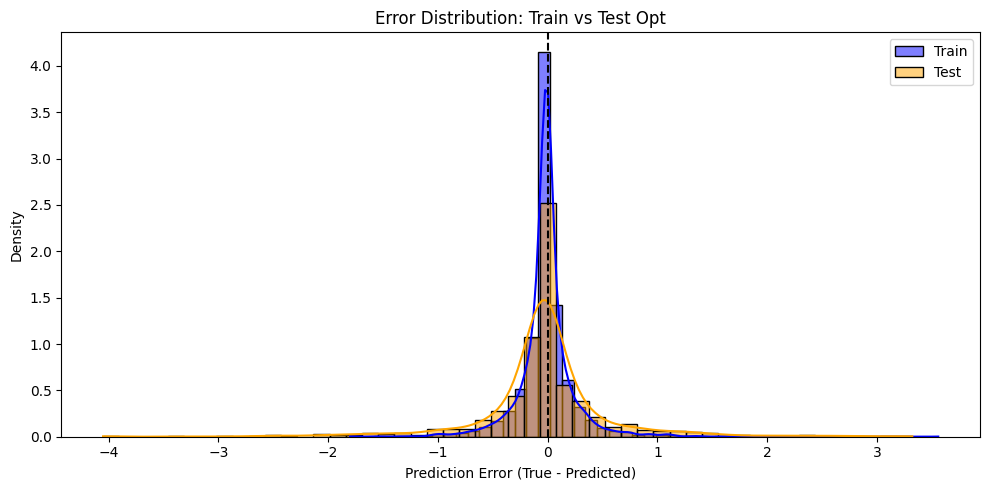

In [7]:
# HYPERPARAMETER TUNING WITH CROSS-VALIDATION

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define parameter space to search
param_dist = {
    'n_estimators': [500, 800, 1500],
    'max_depth': [20, 50, 80, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Setup the search with 5-fold CV
search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_dist,
    cv=5,
    n_jobs=-1,
)

# Fit the search on training data
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict and evaluate
y_train_pred_opt = best_model.predict(X_train)
y_test_pred_opt = best_model.predict(X_test)

# Training set metrics
train_mae_opt = mean_absolute_error(y_train, y_train_pred_opt)
train_rmse_opt = np.sqrt(mean_squared_error(y_train, y_train_pred_opt))
train_r2_opt = r2_score(y_train, y_train_pred_opt)

# Test set metrics
test_mae_opt = mean_absolute_error(y_test, y_test_pred_opt)
test_rmse_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))
test_r2_opt = r2_score(y_test, y_test_pred_opt)

print(search.best_params_)

print("\nOptimized RF:")

# Print both
print("Training Performance Opt")
print(f"MAE: {train_mae_opt:.3f}, RMSE: {train_rmse_opt:.3f}, R²: {train_r2_opt:.3f}")

print("\nTest Performance Opt")
print(f"MAE: {test_mae_opt:.3f}, RMSE: {test_rmse_opt:.3f}, R²: {test_r2_opt:.3f}")

# Visualisation of optimisation

plt.figure(figsize=(6, 6))

# Training predictions
plt.scatter(y_train, y_train_pred_opt, alpha=0.4, label="Train", color="skyblue")

# Test predictions
plt.scatter(y_test, y_test_pred_opt, alpha=0.4, label="Test", color="salmon")

# Reference line
min_val = min(y.min(), y_train_pred_opt.min(), y_test_pred_opt.min())
max_val = max(y.max(), y_train_pred_opt.max(), y_test_pred_opt.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs True Band Gap Opt")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate residuals (errors)
train_errors_opt = y_train - y_train_pred_opt
test_errors_opt = y_test - y_test_pred_opt

plt.figure(figsize=(10, 5))
sns.histplot(train_errors_opt, kde=True, color="blue", label="Train", stat="density", bins=50)
sns.histplot(test_errors_opt, kde=True, color="orange", label="Test", stat="density", bins=50)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Prediction Error (True - Predicted)")
plt.ylabel("Density")
plt.title("Error Distribution: Train vs Test Opt")
plt.legend()
plt.tight_layout()
plt.show()

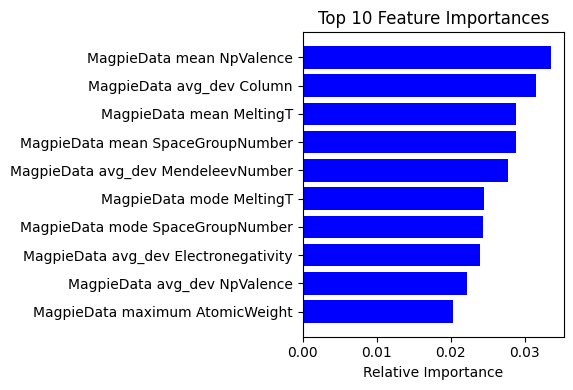

MagpieData maximum AtomicWeight: 0.0203
MagpieData avg_dev NpValence: 0.0222
MagpieData avg_dev Electronegativity: 0.0240
MagpieData mode SpaceGroupNumber: 0.0243
MagpieData mode MeltingT: 0.0245
MagpieData avg_dev MendeleevNumber: 0.0277
MagpieData mean SpaceGroupNumber: 0.0287
MagpieData mean MeltingT: 0.0289
MagpieData avg_dev Column: 0.0315
MagpieData mean NpValence: 0.0336


In [8]:
# Show top 10 feature importances
importances = best_model.feature_importances_
features = X_train.columns
top_n = 10

indices = np.argsort(importances)[-top_n:]  # get top 10 indices

plt.figure(figsize=(6, 4))
plt.title(f"Top {top_n} Feature Importances")
plt.barh(range(top_n), importances[indices], color='b', align='center')
plt.yticks(range(top_n), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

for i in indices:
    print(f"{features[i]}: {importances[i]:.4f}")

### Final Model Evaluation Summary

| Model                        | MAE (eV) | RMSE (eV) | R² Score |
|-----------------------------|----------|-----------|----------|
| **Baseline Random Forest**   | 0.334    | 0.642     | 0.832    |
| **Optimized RF (GridSearchCV)** | 0.338    | 0.623     | 0.841    |

